#Prepocessing

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from nltk.stem.snowball import EnglishStemmer
import re

print("Tensorflow Version",tf.__version__)

import warnings 
warnings.filterwarnings('ignore')

Tensorflow Version 2.11.0


## Dataset details
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

In [ ]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = 'ISO-8859-1',header=None, index_col=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.rename(columns={0:"target",1: "ids",2: "date",3: "flag",4: "user", 5:"text"},
          inplace=True, errors='raise')
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
# Removing the unnecessary columns.
df = df[['target','text']]
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.target.unique().tolist()

[0, 4]

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-e': 'vampire', ':(': 'sad',":'(" :'sad', '*sight*':'sad',
          ':-(': 'sad', ':-<': 'sad', ':p': 'raspberry', ':o': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-d': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'o:-)': 'angel','o*-)': 'angel','(:-d': 'gossip', '=^.^=': 'cat', ';d':'lol'}

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
# LowerCase text
df['cleaned']=df['text'].apply(lambda x: x.lower())

In [ ]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

In [ ]:
# Replace all emojis.
for emoji in emojis.keys():
    df['cleaned']=df['cleaned'].apply(lambda x: x.replace(emoji, "EMOJI " + emojis[emoji]))

In [ ]:
# Remove url Pattern
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)',' ', x))

In [ ]:
# Remove user Pattern
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(userPattern,' ', x))

In [ ]:
# Remove alpha Pattern
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(alphaPattern,' ', x))

In [ ]:
# Replace two or more consecutive repetitions of a letter with two of the same
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(sequencePattern, seqReplacePattern, x))

In [ ]:
#Remove digits and words containing digits
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [ ]:
for index,text in enumerate(df['cleaned'][0:6]):
    print('Text %d:\n'%(index+1),text)

Text 1:
   aww  that s a bummer  you shoulda got david carr of third day to do it  EMOJI llo
Text 2:
 is upset that he can t update his facebook by texting it  and might cry as a result  school today also  blah 
Text 3:
   i dived many times for the ball  managed to save   the rest go out of bounds
Text 4:
 my whole body feels itchy and like its on fire 
Text 5:
   no  it s not behaving at all  i m mad  why am i here  because i can t see you all over there  
Text 6:
   not the whole crew 


In [ ]:
# Removing extra spaces
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

## Remove stop words and lemmatize 

In [ ]:
#convert cleaned text into tokens
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
df['tokens'] = df['cleaned'].apply(lambda x:tokenizer.tokenize(x))
df.head()

,target,text,cleaned,tokens
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that s a bummer you shoulda got david car...,"[aww, that, s, a, bummer, you, shoulda, got, d..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...,"[is, upset, that, he, can, t, update, his, fac..."
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i ...,"[no, it, s, not, behaving, at, all, i, m, mad,..."


In [ ]:
stop_words = set(stopwords.words("english"))
def remove_stopwords(text):
    words = [w for w in text if w not in stop_words]
    return words 
df['stopwordremove_tokens'] = df['tokens'].apply(lambda x : remove_stopwords(x))
df.head()

,target,text,cleaned,tokens,stopwordremove_tokens
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that s a bummer you shoulda got david car...,"[aww, that, s, a, bummer, you, shoulda, got, d...","[aww, bummer, shoulda, got, david, carr, third..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...,"[is, upset, that, he, can, t, update, his, fac...","[upset, update, facebook, texting, might, cry,..."
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, rest..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i ...,"[no, it, s, not, behaving, at, all, i, m, mad,...","[behaving, mad, see]"


In [ ]:
# lemmatization
lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]

df['lemmatized_text'] = df['stopwordremove_tokens'].apply(lem_word)

In [ ]:

def emoji_count(w):
    
    return w.count('EMOJI') 

df['emoji_count'] = df['lemmatized_text'].apply(emoji_count)

In [ ]:
def emoji_list(wlist):
  return [word for word in wlist if wlist[wlist.index(word)-1] == 'EMOJI']

df['emoji_list'] = df['lemmatized_text'].apply(emoji_list)

In [ ]:
def combine_text(list_of_text):
    
    combined_text = ' '.join(list_of_text)
    return combined_text

df['final_text'] = df['lemmatized_text'].apply(lambda x : combine_text(x))
df.head()

,target,text,cleaned,tokens,stopwordremove_tokens,lemmatized_text,emoji_count,emoji_list,final_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that s a bummer you shoulda got david car...,"[aww, that, s, a, bummer, you, shoulda, got, d...","[aww, bummer, shoulda, got, david, carr, third...","[aww, bummer, shoulda, got, david, carr, third...",1,[llo],aww bummer shoulda got david carr third day EM...
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...,"[is, upset, that, he, can, t, update, his, fac...","[upset, update, facebook, texting, might, cry,...","[upset, update, facebook, texting, might, cry,...",0,[],upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, rest...","[dived, many, time, ball, managed, save, rest,...",0,[],dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, body, feel, itchy, like, fire]",0,[],whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i ...,"[no, it, s, not, behaving, at, all, i, m, mad,...","[behaving, mad, see]","[behaving, mad, see]",0,[],behaving mad see


In [ ]:
df1 = df[['target','final_text']]
df1.head()

,target,final_text
0,0,aww bummer shoulda got david carr third day EM...
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see


# Analysis

### The Ratio of Negative and Positive

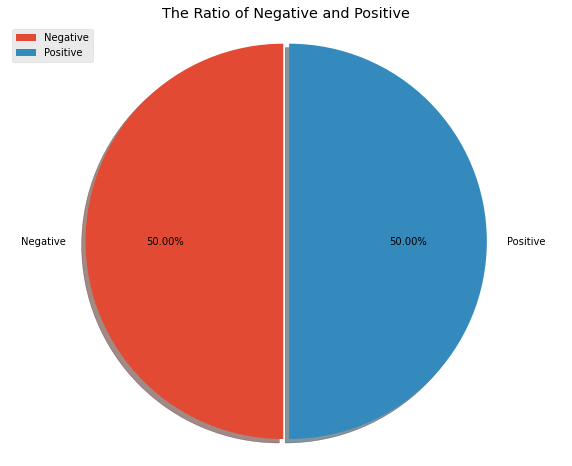

In [ ]:
data_pie = df[['target']].value_counts()
data_pie
labels = ['Negative','Positive']
explode = (0.03,0)
plt.style.use('ggplot')
plt.subplots(figsize=(10,8)) 
plt.title('The Ratio of Negative and Positive')
plt.pie(x=data_pie, explode=explode, labels=labels, autopct='%.2f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

Sự phân bổ của nhóm bài viết tích cực và tiêu cực là như nhau, đều bằng 50%. 

### Average Level 

In [ ]:
def wl(x):
  return len(x.split(" "));

In [ ]:
df_negative = pd.DataFrame()
df_negative = df1[df1.target == 0]
df_negative

,target,final_text
0,0,aww bummer shoulda got david carr third day EM...
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see
...,...,...
799995,0,sick spending day laying bed listening
799996,0,gmail
799997,0,rest peace farrah sad
799998,0,sound like rival flagging ad much though


In [ ]:
df_negative['word_count']=df_negative['final_text'].apply(wl)
df_negative

,target,final_text,word_count
0,0,aww bummer shoulda got david carr third day EM...,10
1,0,upset update facebook texting might cry result...,11
2,0,dived many time ball managed save rest go bound,9
3,0,whole body feel itchy like fire,6
4,0,behaving mad see,3
...,...,...,...
799995,0,sick spending day laying bed listening,6
799996,0,gmail,1
799997,0,rest peace farrah sad,4
799998,0,sound like rival flagging ad much though,7


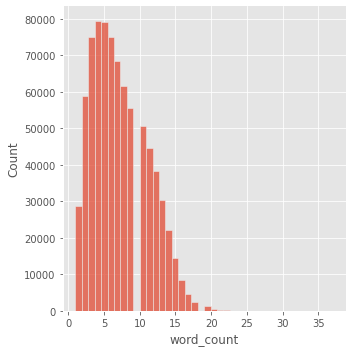

In [ ]:
import seaborn as sns
sns.displot(df_negative['word_count'], bins=40, kde=False)

Từ biểu đồ trên cho thấy, độ dài trung bình của một tweet thuộc Negative dao động từ 5 tới 7 từ, cao nhất là tầm 7 từ.

In [ ]:
df_positive = pd.DataFrame()
df_positive = df1[df1.target == 4]
df_positive

,target,final_text
800000,4,love u guy r best
800001,4,im meeting one besties tonight cant wait girl ...
800002,4,thanks twitter add sunisa got meet hin show dc...
800003,4,sick really cheap hurt much eat real food plus...
800004,4,effect everyone
...,...,...
1599995,4,woke school best feeling ever
1599996,4,thewdb com cool hear old walt interview
1599997,4,ready mojo makeover ask detail
1599998,4,happy birthday boo time tupac amaru shakur


In [ ]:
df_positive['word_count']=df_positive['final_text'].apply(wl)
df_positive

,target,final_text,word_count
800000,4,love u guy r best,5
800001,4,im meeting one besties tonight cant wait girl ...,9
800002,4,thanks twitter add sunisa got meet hin show dc...,11
800003,4,sick really cheap hurt much eat real food plus...,12
800004,4,effect everyone,2
...,...,...,...
1599995,4,woke school best feeling ever,5
1599996,4,thewdb com cool hear old walt interview,7
1599997,4,ready mojo makeover ask detail,5
1599998,4,happy birthday boo time tupac amaru shakur,7


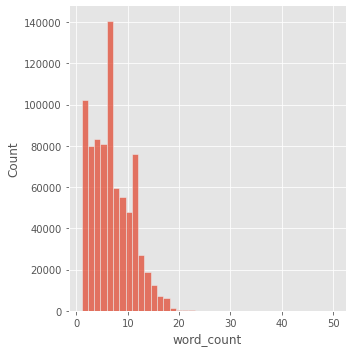

In [ ]:
sns.displot(df_positive['word_count'], bins=40, kde=False)

Từ biểu đồ trên cho thấy, độ dài trung bình của một tweet thuộc Positive cũng dao động tầm 7 từ, cao nhất rơi vào 2 từ, 7 từ và 11 từ.

## word cloud

In [ ]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [ ]:
data_ne = pd.DataFrame()
data_ne = df1[df1.target == 0]
data_ne

,target,final_text
0,0,aww bummer shoulda got david carr third day EM...
1,0,upset update facebook texting might cry result...
2,0,dived many time ball managed save rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see
...,...,...
799995,0,sick spending day laying bed listening
799996,0,gmail
799997,0,rest peace farrah sad
799998,0,sound like rival flagging ad much though


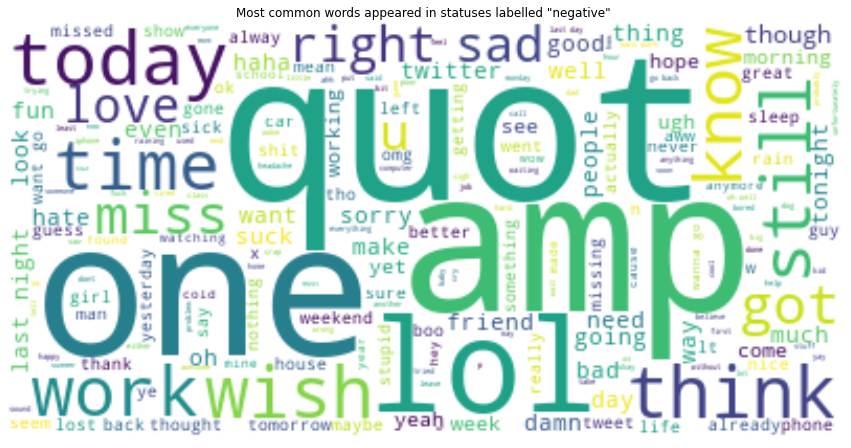

In [ ]:
text_ne = " ".join(i for i in data_ne['final_text'])
stopwords = set(STOPWORDS)
wordcloud_ne = WordCloud(stopwords=stopwords, background_color="white").generate(text_ne)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud_ne, interpolation='bilinear')
plt.title('Most common words appeared in statuses labelled "negative" ')
plt.axis("off")
plt.show()

Các từ phổ biến nhất trong nhóm bài viết tiêu cực là: quot, amp, one, lol, think, work, miss, today, time, wish -> những từ này không thể hiện rõ tâm trạng buồn chán, tiêu cực của người đăng. Tuy nhiên các từ thể hiện rõ sự tiêu cực như sad, hate, bad, suck,... có thể dễ dàng nhìn ra trong hình trên, tần suất các từ này xuất hiện trong các bài đăng được gán nhãn "tiêu cực" ở mức khá thường xuyên.

In [ ]:
data_po = pd.DataFrame()
data_po = df1[df.target == 4]
data_po

,target,final_text
800000,1,love u guy r best
800001,1,im meeting one besties tonight cant wait girl ...
800002,1,thanks twitter add sunisa got meet hin show dc...
800003,1,sick really cheap hurt much eat real food plus...
800004,1,effect everyone
...,...,...
1599995,1,woke school best feeling ever
1599996,1,thewdb com cool hear old walt interview
1599997,1,ready mojo makeover ask detail
1599998,1,happy birthday boo time tupac amaru shakur


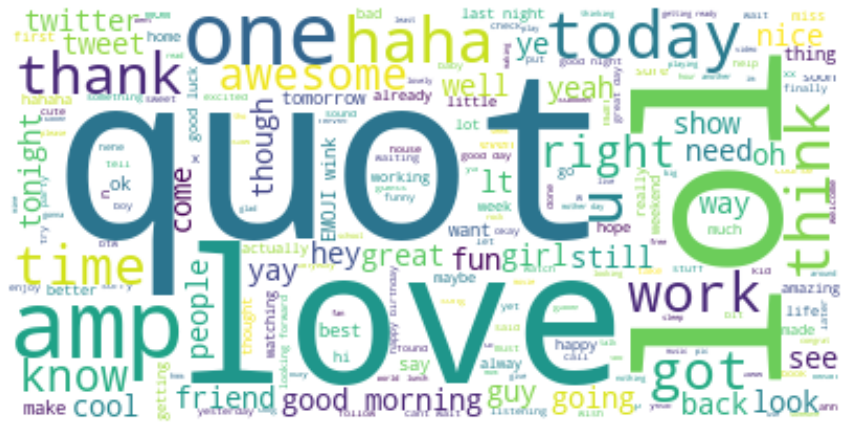

In [ ]:
text_po = " ".join(i for i in data_po['final_text'])
stopwords = set(STOPWORDS)
wordcloud_po = WordCloud(stopwords=stopwords, background_color="white").generate(text_po)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud_po, interpolation='bilinear')
plt.axis("off")
plt.show()

Các từ phổ biến nhất trong nhóm bài viết tích cực là: love, quot, amp, lol, one, haha, thank, awesome, well.  Đây là những từ thể hiện rõ sự tích cực, tâm trạng vui vẻ của người đăng. Các từ khác cũng mang ý nghĩa tích cực và có tần suất xuất hiện ở mức khá thường xuyên đó là nice, great, good morning, fun, yay, cool

## Emoji

In [ ]:
data_icon = df[['target', 'final_text', 'emoji_count']]
data_icon

,target,final_text,emoji_count
0,0,aww bummer shoulda got david carr third day EM...,1
1,0,upset update facebook texting might cry result...,0
2,0,dived many time ball managed save rest go bound,0
3,0,whole body feel itchy like fire,0
4,0,behaving mad see,0
...,...,...,...
1599995,4,woke school best feeling ever,0
1599996,4,thewdb com cool hear old walt interview,0
1599997,4,ready mojo makeover ask detail,0
1599998,4,happy birthday boo time tupac amaru shakur,0


In [ ]:
index_emo = sorted(list(data_icon['emoji_count'].unique()))
index_emo

[0, 1, 2, 3, 4, 5, 6, 10, 11]

In [ ]:
d_emoji = pd.DataFrame(index=index_emo)
emo_ne_gb = data_icon[data_icon['target'] == 0].groupby ('emoji_count')['emoji_count'].count()
d_emoji['Count (Ne)'] = emo_ne_gb
emo_po_gb = data_icon[data_icon['target'] == 4].groupby ('emoji_count')['emoji_count'].count()
d_emoji['Count (Po)'] = emo_po_gb
display(d_emoji)

,Count (Ne),Count (Po)
0,792594,791708.0
1,7155,8101.0
2,203,178.0
3,34,11.0
4,7,1.0
5,4,NaN
6,1,1.0
10,1,NaN
11,1,NaN


In [ ]:
d_emoji = d_emoji.fillna(0)
d_emoji

,Count (Ne),Count (Po)
0,792594,791708.0
1,7155,8101.0
2,203,178.0
3,34,11.0
4,7,1.0
5,4,0.0
6,1,1.0
10,1,0.0
11,1,0.0


Số lượng emoji xuất hiện trong các status ở mỗi nhóm tích cực và tiêu cực có sự chênh lệch. Trong nhóm bài viết tích cực, phần lớn các bài viết không sử dụng emoji hoặc dùng 1 emoji. Còn với các bài viết tiêu cực, khi dùng emoji để thể hiện tâm trạng, số lượng dùng emoji dao động từ 1-3, và có thể sử dụng tận 10-11 emoji trong 1 bài viết

###EmojiCloud

In [ ]:
data_icon = df[['target', 'final_text', 'emoji_count', 'emoji_list']]
data_icon

,target,final_text,emoji_count,emoji_list
0,0,aww bummer shoulda got david carr third day EM...,1,[llo]
1,0,upset update facebook texting might cry result...,0,[]
2,0,dived many time ball managed save rest go bound,0,[]
3,0,whole body feel itchy like fire,0,[]
4,0,behaving mad see,0,[]
...,...,...,...,...
1599995,4,woke school best feeling ever,0,[]
1599996,4,thewdb com cool hear old walt interview,0,[]
1599997,4,ready mojo makeover ask detail,0,[]
1599998,4,happy birthday boo time tupac amaru shakur,0,[]


In [ ]:
data_icon.sort_values('emoji_count', ascending = False, inplace=True)

In [ ]:
data_icon

,target,final_text,emoji_count,emoji_list
594642,0,hate job scratch hate life EMOJI shocked EMOJI...,11,"[shocked, shocked, shocked, shocked, shocked, ..."
594449,0,going meet best friend chris EMOJI wink EMOJI ...,10,"[wink, wink, wink, wink, wink, wink, wink, win..."
679678,0,EMOJI wink p gt EMOJI surprised EMOJI confused...,6,"[wink, surprised, confused, confused, sad, smile]"
1060248,4,hey take look zing wish EMOJI wink EMOJI wink ...,6,"[wink, wink, wink, wink, wink, wink]"
623897,0,missed radiohead EMOJI shocked EMOJI shocked E...,5,"[shocked, shocked, shocked, shocked, shocked]"
...,...,...,...,...
535828,0,sorry cry twitter thing make hard express peop...,0,[]
535827,0,town wish could go ak,0,[]
535826,0,dont laugh im raising sware feel like let mama...,0,[]
535825,0,bummed gonna miss ignitephx home flu,0,[]


In [ ]:
data_icon['emoji_list'] = data_icon['emoji_list'].apply(lambda x : combine_text(x))
data_icon.head()

,target,final_text,emoji_count,emoji_list
594642,0,hate job scratch hate life EMOJI shocked EMOJI...,11,shocked shocked shocked shocked shocked shocke...
594449,0,going meet best friend chris EMOJI wink EMOJI ...,10,wink wink wink wink wink wink wink wink wink wink
679678,0,EMOJI wink p gt EMOJI surprised EMOJI confused...,6,wink surprised confused confused sad smile
1060248,4,hey take look zing wish EMOJI wink EMOJI wink ...,6,wink wink wink wink wink wink
623897,0,missed radiohead EMOJI shocked EMOJI shocked E...,5,shocked shocked shocked shocked shocked


In [ ]:
data_icon_ne = pd.DataFrame()
data_icon_ne = data_icon[data_icon.target == 0]

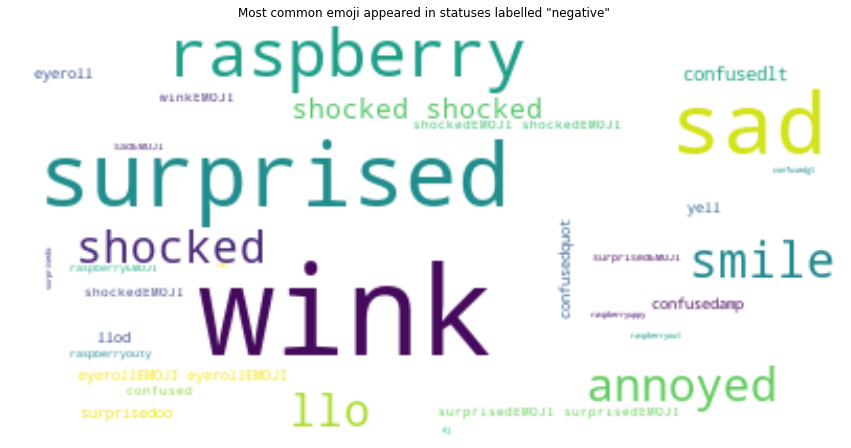

In [ ]:
icon_ne = " ".join(i for i in data_icon_ne['emoji_list'])
stopwords = set(STOPWORDS)
wordcloud_icon_ne = WordCloud(stopwords=stopwords, background_color="white").generate(icon_ne)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud_icon_ne, interpolation='bilinear')
plt.title('Most common emoji appeared in statuses labelled "negative" ')
plt.axis("off")
plt.show()

Các emoji xuất hiện nhiều nhất trong các bài viết tiêu cực là:
* sad: ':(', ':'(', '* sight *', ':-(', ':-<' 
* surprised: ':o'
* shocked: ':-@', ':@'
* wink: ';)', ';-)'
* raspberry: ':p'
* annoyed: ':\\'

Các emoji thể hiện rõ tâm trạng tiêu cực như sad, shocked, annoyed xuất hiện nhiều trong các bài viết được gán nhãn tiêu cực. Điều này cho thấy việc thể hiện cảm xúc, tâm trạng qua hình vẽ, emoji dễ hơn là qua câu từ trực tiếp.

In [ ]:
data_icon_po = pd.DataFrame()
data_icon_po = data_icon[data_icon.target == 4]

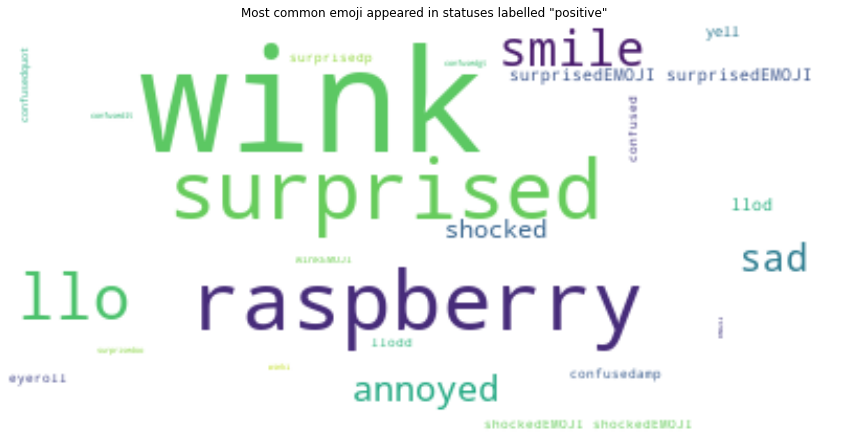

In [ ]:
icon_po = " ".join(i for i in data_icon_po['emoji_list'])
stopwords = set(STOPWORDS)
wordcloud_icon_po = WordCloud(stopwords=stopwords, background_color="white").generate(icon_po)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud_icon_po, interpolation='bilinear')
plt.title('Most common emoji appeared in statuses labelled "positive" ')
plt.axis("off")
plt.show()

Các emoji xuất hiện nhiều nhất trong các bài viết tích cực là:
* smile: ':)', ':-)', ':^)'
* lol: ';p'
* surprised: ':o'
* wink: ';)', ';-)', ';p'
* raspberry: ':p'

Các emoji thể hiện rõ tâm trạng tích cực như smile, lol, wink, raspberry xuất hiện nhiều trong các bài viết được gán nhãn tích cực. Điều này cho thấy việc thể hiện cảm xúc, tâm trạng qua hình vẽ, emoji dễ hơn là qua câu từ trực tiếp.

# Model Evaluate


## Train and Test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#relace value 4 to 1
data['target'][data['target']==4]=1
X=data.final_text
y=data.target

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.02, random_state=2)

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=1000000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

## Tranforming the dataset

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

## Evaluate model function

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(Y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(Y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### SVM

In [ ]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     15924
           1       0.77      0.79      0.78     16076

    accuracy                           0.78     32000
   macro avg       0.78      0.78      0.78     32000
weighted avg       0.78      0.78      0.78     32000



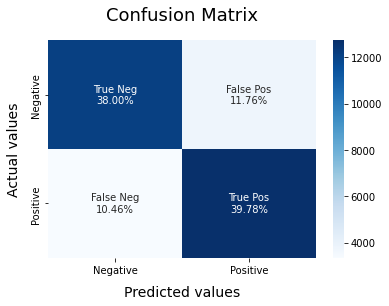

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, Y_train)
model_Evaluate(SVCmodel)

## Decisiontree

              precision    recall  f1-score   support

           0       0.80      0.30      0.44     15924
           1       0.57      0.93      0.71     16076

    accuracy                           0.62     32000
   macro avg       0.69      0.61      0.57     32000
weighted avg       0.69      0.62      0.57     32000



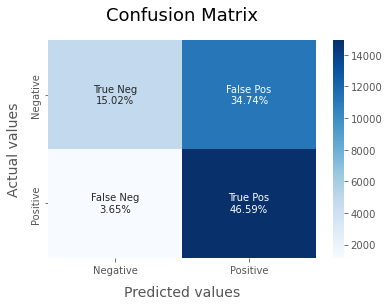

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_2 = DecisionTreeClassifier(max_depth = 20, random_state= 41, 
                                 max_features =None , min_samples_leaf = 30).fit(X_train, Y_train)
model_Evaluate(dtree_2)

###Classification result using SVM method

In [ ]:
predictions_SVM = SVCmodel.predict(X_test)

In [ ]:
data_modelSVM['SVM prediction'] = predictions_SVM

In [ ]:
data_modelSVM['Original Label'] = Y_test

In [ ]:
data_modelSVM['Correction'] = data_modelSVM.apply(lambda x: 'Right' if x['SVM prediction'] == x['Original Label'] else 'Wrong', axis=1)

In [ ]:
data_modelSVM

,Status,SVM prediction,Original Label,Correction
670081,oh im going wow mona vale real place afterall ...,0,0,Right
408251,baby growing,0,0,Right
1559739,painted black rolling stone best,1,1,Right
571248,kk logging byezz,1,0,Wrong
524639,shitty shitty shitty news today,0,0,Right
...,...,...,...,...
380683,hacked mine username kristenjstewart make one,1,0,Wrong
475445,hate smell hospital brings back bad memory,0,0,Right
1413672,enough office buy something tasty supper back ...,1,1,Right
1048028,yeah reinstall find login let know mate,0,1,Wrong


In [ ]:
print('Tỷ lệ dự đoán đúng:', str(round(data_modelSVM[data_modelSVM['Correction']=='Right']['Correction'].count()/len(data_modelSVM),2)*100)+'%')

Tỷ lệ dự đoán đúng: 78.0%


In [ ]:
import plotly.express as px
fig = px.sunburst(data_modelSVM,
                  path=["SVM prediction", 'Correction'],
                  )
fig.show()

Tỷ lệ phân loại đúng của cả 2 nhóm tích cực và tiêu cực đều chiếm khoảng 4/5 trong từng nhóm.

In [ ]:
data_model_ne = pd.DataFrame()
data_model_ne = data_modelSVM[data_modelSVM['SVM prediction'] == 0]
data_model_ne

,Status,SVM prediction,Original Label,Correction
670081,oh im going wow mona vale real place afterall ...,0,0,Right
408251,baby growing,0,0,Right
524639,shitty shitty shitty news today,0,0,Right
311150,hug wrong,0,0,Right
145612,heard upsetting spoiler sytycd top depressed,0,0,Right
...,...,...,...,...
95638,received weird error aka could authenticate us...,0,0,Right
355250,missed season premier burn notice fell asleep ...,0,0,Right
235069,nope sleeping lap,0,0,Right
475445,hate smell hospital brings back bad memory,0,0,Right


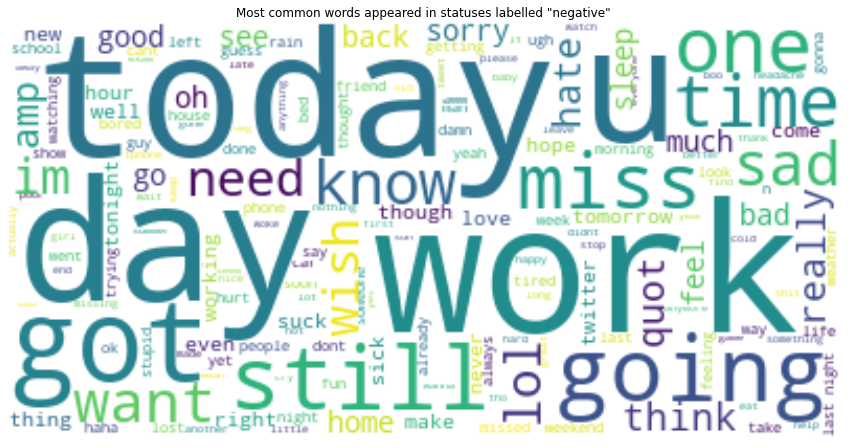

In [ ]:
text_ne = " ".join(i for i in data_model_ne['Status'])
stopwords = set(STOPWORDS)
wordcloud_ne = WordCloud(stopwords=stopwords, background_color="white").generate(text_ne)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_ne, interpolation='bilinear')
plt.title('Most common words appeared in statuses labelled "negative" ')
plt.axis("off")
plt.show()

Những từ phổ biến nhất đối với các bài viết được phân loại là "tiêu cực" gồm: today, day, got, one, work, u, stil, know, going. Những từ này không thể hiện quá rõ cảm xúc tiêu cực của người viết. Các từ thể hiện rõ thái độ tiêu cực như hate, sad, sorry, wish, tired, bad tuy có xuất hiện trong các bài viết thuộc nhóm tiêu cực này nhưng ở tần suất vừa đến thấp, không được sử dụng nhiều.

In [ ]:
data_model_po = pd.DataFrame()
data_model_po = data_modelSVM[data_modelSVM['SVM prediction'] == 1]
data_model_po

,Status,SVM prediction,Original Label,Correction
1559739,painted black rolling stone best,1,1,Right
571248,kk logging byezz,1,0,Wrong
591282,ipod touch care great,1,0,Wrong
488533,haha meant jog job ahh sunburned,1,0,Wrong
1559193,im good enjoying laker win west everything goo...,1,1,Right
...,...,...,...,...
1150154,shower amp going sleep,1,1,Right
1539971,great tool help effectively grow business let ...,1,1,Right
380683,hacked mine username kristenjstewart make one,1,0,Wrong
1413672,enough office buy something tasty supper back ...,1,1,Right


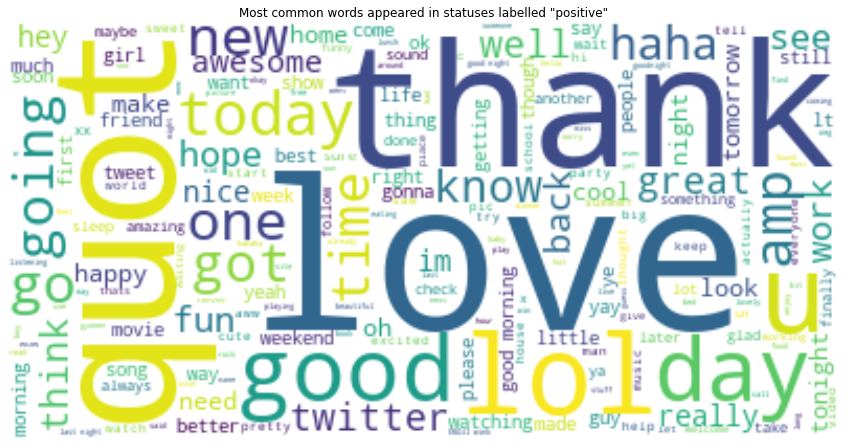

In [ ]:
text_po = " ".join(i for i in data_model_po['Status'])
stopwords = set(STOPWORDS)
wordcloud_po = WordCloud(stopwords=stopwords, background_color="white").generate(text_po)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_po, interpolation='bilinear')
plt.title('Most common words appeared in statuses labelled "positive" ')
plt.axis("off")
plt.show()

Những từ phổ biến nhất trong nhóm các bài đăng tích cực là: love, quot, thank, u, lol, good, well, today, haha, day, know, time. Phần lớn các từ trên đều thể hiện rõ tâm trạng vui vẻ, thoải mái, tích cực của người viết.